In [2]:
import requests
import pandas as pd
import time
from tqdm import tqdm
import numpy as np
from cmdstanpy import CmdStanModel
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
BASE_URL = "https://api.server.nbaapi.com/api"

START_SEASON = 2015
END_SEASON = 2025
# Define a delay between API calls to be a good citizen
REQUEST_DELAY_SECONDS = 1

def fetch_all_pages(endpoint: str, season: int) -> list:

    all_records = []
    current_page = 1
    total_pages = 1

    print(f"   Fetching from endpoint: {endpoint}...")

    while current_page <= total_pages:
        params = {
            'season': season,
            'isPlayoff': 'false',
            'page': current_page,
            'pageSize': 50
        }

        try:
            response = requests.get(f"{BASE_URL}/{endpoint}", params=params)
            response.raise_for_status()

            data = response.json()

            records = data.get('data', [])
            if not records:
                break

            all_records.extend(records)

            if current_page == 1:
                total_pages = data.get('pagination', {}).get('pages', 1)

            current_page += 1
            time.sleep(REQUEST_DELAY_SECONDS)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {current_page} for {season} from {endpoint}: {e}")
            break

    return all_records


if __name__ == "__main__":
    all_seasons_totals = []
    all_seasons_advanced = []

    seasons_to_fetch = range(START_SEASON, END_SEASON + 1)

    for season in tqdm(seasons_to_fetch, desc="Processing Seasons"):
        print(f"\nFetching data for the {season} season...")

        totals_data = fetch_all_pages("playertotals", season)
        advanced_data = fetch_all_pages("playeradvancedstats", season)

        all_seasons_totals.extend(totals_data)
        all_seasons_advanced.extend(advanced_data)

    print("\nData fetching complete. Processing and merging data...")

    totals_df = pd.DataFrame(all_seasons_totals)
    advanced_df = pd.DataFrame(all_seasons_advanced)

    totals_df_selected = totals_df[[
        'playerId', 'season', 'playerName', 'position', 'age', 'team', 'games',
        'points', 'assists', 'totalRb', 'offensiveRb', 'defensiveRb',
        'steals', 'blocks', 'turnovers', 'personalFouls', 'fieldAttempts',
        'fieldGoals', 'threeAttempts', 'threeFg', 'ftAttempts', 'ft'
    ]].copy()

    advanced_df_selected = advanced_df[[
        'playerId', 'season', 'minutesPlayed', 'tsPercent', 'usagePercent',
        'offensiveWS', 'defensiveWS', 'winShares', 'vorp', 'box'
    ]].copy()

    merged_df = pd.merge(
        totals_df_selected,
        advanced_df_selected,
        on=['playerId', 'season'],
        how='outer'
    )

    stats_to_convert = [
        'points', 'assists', 'totalRb', 'offensiveRb', 'defensiveRb', 'steals',
        'blocks', 'turnovers', 'personalFouls', 'fieldAttempts', 'fieldGoals',
        'threeAttempts', 'threeFg', 'ftAttempts', 'ft'
    ]

    for stat in stats_to_convert:
        merged_df[f'total_{stat}'] = merged_df[stat] * merged_df['games']

    player_df = merged_df.drop(columns=stats_to_convert)
    column_order = [
        'playerId', 'playerName', 'season', 'age', 'team', 'position', 'games', 'minutesPlayed',
        'total_points', 'total_assists', 'total_totalRb', 'total_offensiveRb', 'total_defensiveRb',
        'total_steals', 'total_blocks', 'total_turnovers', 'total_personalFouls',
        'total_fieldAttempts', 'total_fieldGoals', 'total_threeAttempts', 'total_threeFg',
        'total_ftAttempts', 'total_ft',
        'tsPercent', 'usagePercent', 'offensiveWS', 'defensiveWS', 'winShares', 'vorp', 'box'
    ]
    player_df = player_df[column_order]

    output_filename = f"nba_player_data_{START_SEASON}-{END_SEASON}.csv"
    player_df.to_csv(output_filename, index=False)

'BASE_URL = "https://api.server.nbaapi.com/api"\n\nSTART_SEASON = 2015\nEND_SEASON = 2025\n# Define a delay between API calls to be a good citizen\nREQUEST_DELAY_SECONDS = 1\n\ndef fetch_all_pages(endpoint: str, season: int) -> list:\n\n    all_records = []\n    current_page = 1\n    total_pages = 1\n\n    print(f"   Fetching from endpoint: {endpoint}...")\n\n    while current_page <= total_pages:\n        params = {\n            \'season\': season,\n            \'isPlayoff\': \'false\',\n            \'page\': current_page,\n            \'pageSize\': 50\n        }\n\n        try:\n            response = requests.get(f"{BASE_URL}/{endpoint}", params=params)\n            response.raise_for_status()\n\n            data = response.json()\n\n            records = data.get(\'data\', [])\n            if not records:\n                break\n\n            all_records.extend(records)\n\n            if current_page == 1:\n                total_pages = data.get(\'pagination\', {}).get(\'pages\', 1

In [3]:
player_df = pd.read_csv('full_model/nba_player_data_2015-2025.csv')
team_df = pd.read_csv('full_model/nba_team_stats_00_to_23.csv')

team_df['season'] = 2000 + team_df['season'].str[-2:].astype(int)

In [60]:
nba_2025_team_stats = [
    {'Team': 'Cleveland Cavaliers', 'games_played': 82, 'wins': 64, 'losses': 18, 'Min': 19755, 'points': 9999, 'field_goals_made': 3652, 'field_goals_attempted': 7444, 'field_goal_percentage': 0.491, 'three_pointers_made': 1303, 'three_pointers_attempted': 3401, 'three_point_percentage': 0.383, 'free_throws_made': 1392, 'free_throw_attempted': 1793, 'free_throw_percentage': 0.776, 'offensive_rebounds': 917, 'defensive_rebounds': 2806, 'rebounds': 3723, 'assists': 2304, 'turnovers': 1082, 'steals': 670, 'blocks': 350, 'personal_fouls': 1487, 'season': 2025},
    {'Team': 'Memphis Grizzlies', 'games_played': 82, 'wins': 48, 'losses': 34, 'Min': 19705, 'points': 9980, 'field_goals_made': 3670, 'field_goals_attempted': 7654, 'field_goal_percentage': 0.479, 'three_pointers_made': 1141, 'three_pointers_attempted': 3106, 'three_point_percentage': 0.367, 'free_throws_made': 1499, 'free_throw_attempted': 1908, 'free_throw_percentage': 0.786, 'offensive_rebounds': 1056, 'defensive_rebounds': 2819, 'rebounds': 3875, 'assists': 2330, 'turnovers': 1285, 'steals': 726, 'blocks': 462, 'personal_fouls': 1711, 'season': 2025},
    {'Team': 'Denver Nuggets', 'games_played': 82, 'wins': 50, 'losses': 32, 'Min': 19855, 'points': 9902, 'field_goals_made': 3724, 'field_goals_attempted': 7360, 'field_goal_percentage': 0.506, 'three_pointers_made': 984, 'three_pointers_attempted': 2619, 'three_point_percentage': 0.376, 'free_throws_made': 1470, 'free_throw_attempted': 1909, 'free_throw_percentage': 0.770, 'offensive_rebounds': 919, 'defensive_rebounds': 2832, 'rebounds': 3751, 'assists': 2542, 'turnovers': 1169, 'steals': 656, 'blocks': 402, 'personal_fouls': 1444, 'season': 2025},
    {'Team': 'Oklahoma City Thunder', 'games_played': 82, 'wins': 68, 'losses': 14, 'Min': 19705, 'points': 9881, 'field_goals_made': 3660, 'field_goals_attempted': 7600, 'field_goal_percentage': 0.482, 'three_pointers_made': 1192, 'three_pointers_attempted': 3184, 'three_point_percentage': 0.374, 'free_throws_made': 1369, 'free_throw_attempted': 1672, 'free_throw_percentage': 0.819, 'offensive_rebounds': 871, 'defensive_rebounds': 2801, 'rebounds': 3672, 'assists': 2202, 'turnovers': 961, 'steals': 847, 'blocks': 465, 'personal_fouls': 1631, 'season': 2025},
    {'Team': 'Atlanta Hawks', 'games_played': 82, 'wins': 40, 'losses': 42, 'Min': 19780, 'points': 9691, 'field_goals_made': 3556, 'field_goals_attempted': 7528, 'field_goal_percentage': 0.472, 'three_pointers_made': 1107, 'three_pointers_attempted': 3089, 'three_point_percentage': 0.358, 'free_throws_made': 1472, 'free_throw_attempted': 1900, 'free_throw_percentage': 0.775, 'offensive_rebounds': 974, 'defensive_rebounds': 2675, 'rebounds': 3649, 'assists': 2426, 'turnovers': 1273, 'steals': 798, 'blocks': 419, 'personal_fouls': 1564, 'season': 2025},
    {'Team': 'Chicago Bulls', 'games_played': 82, 'wins': 39, 'losses': 43, 'Min': 19755, 'points': 9660, 'field_goals_made': 3543, 'field_goals_attempted': 7545, 'field_goal_percentage': 0.470, 'three_pointers_made': 1266, 'three_pointers_attempted': 3447, 'three_point_percentage': 0.367, 'free_throws_made': 1308, 'free_throw_attempted': 1617, 'free_throw_percentage': 0.809, 'offensive_rebounds': 825, 'defensive_rebounds': 2935, 'rebounds': 3760, 'assists': 2383, 'turnovers': 1203, 'steals': 621, 'blocks': 386, 'personal_fouls': 1444, 'season': 2025},
    {'Team': 'Indiana Pacers', 'games_played': 82, 'wins': 50, 'losses': 32, 'Min': 19855, 'points': 9624, 'field_goals_made': 3574, 'field_goals_attempted': 7326, 'field_goal_percentage': 0.488, 'three_pointers_made': 1081, 'three_pointers_attempted': 2934, 'three_point_percentage': 0.368, 'free_throws_made': 1395, 'free_throw_attempted': 1768, 'free_throw_percentage': 0.789, 'offensive_rebounds': 752, 'defensive_rebounds': 2678, 'rebounds': 3430, 'assists': 2398, 'turnovers': 1082, 'steals': 694, 'blocks': 448, 'personal_fouls': 1533, 'season': 2025},
    {'Team': 'Boston Celtics', 'games_played': 82, 'wins': 61, 'losses': 21, 'Min': 19830, 'points': 9534, 'field_goals_made': 3413, 'field_goals_attempted': 7382, 'field_goal_percentage': 0.462, 'three_pointers_made': 1457, 'three_pointers_attempted': 3955, 'three_point_percentage': 0.368, 'free_throws_made': 1251, 'free_throw_attempted': 1565, 'free_throw_percentage': 0.799, 'offensive_rebounds': 933, 'defensive_rebounds': 2783, 'rebounds': 3716, 'assists': 2144, 'turnovers': 973, 'steals': 589, 'blocks': 452, 'personal_fouls': 1303, 'season': 2025},
    {'Team': 'New York Knicks', 'games_played': 82, 'wins': 51, 'losses': 31, 'Min': 19880, 'points': 9494, 'field_goals_made': 3553, 'field_goals_attempted': 7315, 'field_goal_percentage': 0.486, 'three_pointers_made': 1031, 'three_pointers_attempted': 2794, 'three_point_percentage': 0.369, 'free_throws_made': 1357, 'free_throw_attempted': 1696, 'free_throw_percentage': 0.800, 'offensive_rebounds': 890, 'defensive_rebounds': 2607, 'rebounds': 3497, 'assists': 2254, 'turnovers': 1088, 'steals': 671, 'blocks': 324, 'personal_fouls': 1407, 'season': 2025},
    {'Team': 'Sacramento Kings', 'games_played': 82, 'wins': 40, 'losses': 42, 'Min': 19880, 'points': 9490, 'field_goals_made': 3529, 'field_goals_attempted': 7385, 'field_goal_percentage': 0.478, 'three_pointers_made': 1032, 'three_pointers_attempted': 2887, 'three_point_percentage': 0.357, 'free_throws_made': 1400, 'free_throw_attempted': 1738, 'free_throw_percentage': 0.806, 'offensive_rebounds': 901, 'defensive_rebounds': 2723, 'rebounds': 3624, 'assists': 2169, 'turnovers': 1092, 'steals': 620, 'blocks': 357, 'personal_fouls': 1548, 'season': 2025},
    {'Team': 'Milwaukee Bucks', 'games_played': 82, 'wins': 48, 'losses': 34, 'Min': 19755, 'points': 9472, 'field_goals_made': 3445, 'field_goals_attempted': 7082, 'field_goal_percentage': 0.486, 'three_pointers_made': 1161, 'three_pointers_attempted': 3003, 'three_point_percentage': 0.387, 'free_throws_made': 1421, 'free_throw_attempted': 1895, 'free_throw_percentage': 0.750, 'offensive_rebounds': 674, 'defensive_rebounds': 2882, 'rebounds': 3556, 'assists': 2090, 'turnovers': 1097, 'steals': 601, 'blocks': 384, 'personal_fouls': 1469, 'season': 2025},
    {'Team': 'Detroit Pistons', 'games_played': 82, 'wins': 44, 'losses': 38, 'Min': 19805, 'points': 9471, 'field_goals_made': 3503, 'field_goals_attempted': 7363, 'field_goal_percentage': 0.476, 'three_pointers_made': 1051, 'three_pointers_attempted': 2901, 'three_point_percentage': 0.362, 'free_throws_made': 1414, 'free_throw_attempted': 1826, 'free_throw_percentage': 0.774, 'offensive_rebounds': 931, 'defensive_rebounds': 2739, 'rebounds': 3670, 'assists': 2165, 'turnovers': 1219, 'steals': 652, 'blocks': 431, 'personal_fouls': 1695, 'season': 2025},
    {'Team': 'Minnesota Timberwolves', 'games_played': 82, 'wins': 49, 'losses': 33, 'Min': 19830, 'points': 9372, 'field_goals_made': 3364, 'field_goals_attempted': 7182, 'field_goal_percentage': 0.468, 'three_pointers_made': 1233, 'three_pointers_attempted': 3269, 'three_point_percentage': 0.377, 'free_throws_made': 1411, 'free_throw_attempted': 1789, 'free_throw_percentage': 0.789, 'offensive_rebounds': 908, 'defensive_rebounds': 2726, 'rebounds': 3634, 'assists': 2142, 'turnovers': 1186, 'steals': 654, 'blocks': 406, 'personal_fouls': 1498, 'season': 2025},
    {'Team': 'Houston Rockets', 'games_played': 82, 'wins': 52, 'losses': 30, 'Min': 19780, 'points': 9372, 'field_goals_made': 3484, 'field_goals_attempted': 7659, 'field_goal_percentage': 0.455, 'three_pointers_made': 1038, 'three_pointers_attempted': 2938, 'three_point_percentage': 0.353, 'free_throws_made': 1366, 'free_throw_attempted': 1851, 'free_throw_percentage': 0.738, 'offensive_rebounds': 1200, 'defensive_rebounds': 2774, 'rebounds': 3974, 'assists': 1914, 'turnovers': 1139, 'steals': 689, 'blocks': 411, 'personal_fouls': 1557, 'season': 2025},
    {'Team': 'Dallas Mavericks', 'games_played': 82, 'wins': 39, 'losses': 43, 'Min': 19730, 'points': 9364, 'field_goals_made': 3443, 'field_goals_attempted': 7194, 'field_goal_percentage': 0.479, 'three_pointers_made': 1020, 'three_pointers_attempted': 2801, 'three_point_percentage': 0.364, 'free_throws_made': 1458, 'free_throw_attempted': 1894, 'free_throw_percentage': 0.770, 'offensive_rebounds': 828, 'defensive_rebounds': 2702, 'rebounds': 3530, 'assists': 2070, 'turnovers': 1151, 'steals': 636, 'blocks': 445, 'personal_fouls': 1458, 'season': 2025},
    {'Team': 'San Antonio Spurs', 'games_played': 82, 'wins': 34, 'losses': 48, 'Min': 19730, 'points': 9342, 'field_goals_made': 3426, 'field_goals_attempted': 7362, 'field_goal_percentage': 0.465, 'three_pointers_made': 1158, 'three_pointers_attempted': 3246, 'three_point_percentage': 0.357, 'free_throws_made': 1332, 'free_throw_attempted': 1721, 'free_throw_percentage': 0.774, 'offensive_rebounds': 896, 'defensive_rebounds': 2685, 'rebounds': 3581, 'assists': 2348, 'turnovers': 1138, 'steals': 674, 'blocks': 455, 'personal_fouls': 1363, 'season': 2025},
    {'Team': 'Golden State Warriors', 'games_played': 82, 'wins': 48, 'losses': 34, 'Min': 19730, 'points': 9331, 'field_goals_made': 3342, 'field_goals_attempted': 7412, 'field_goal_percentage': 0.451, 'three_pointers_made': 1264, 'three_pointers_attempted': 3475, 'three_point_percentage': 0.364, 'free_throws_made': 1383, 'free_throw_attempted': 1811, 'free_throw_percentage': 0.764, 'offensive_rebounds': 1029, 'defensive_rebounds': 2692, 'rebounds': 3721, 'assists': 2386, 'turnovers': 1152, 'steals': 771, 'blocks': 391, 'personal_fouls': 1571, 'season': 2025},
    {'Team': 'Phoenix Suns', 'games_played': 82, 'wins': 36, 'losses': 46, 'Min': 19830, 'points': 9317, 'field_goals_made': 3381, 'field_goals_attempted': 7075, 'field_goal_percentage': 0.478, 'three_pointers_made': 1176, 'three_pointers_attempted': 3112, 'three_point_percentage': 0.378, 'free_throws_made': 1379, 'free_throw_attempted': 1702, 'free_throw_percentage': 0.810, 'offensive_rebounds': 783, 'defensive_rebounds': 2701, 'rebounds': 3484, 'assists': 2277, 'turnovers': 1153, 'steals': 593, 'blocks': 392, 'personal_fouls': 1471, 'season': 2025},
    {'Team': 'Los Angeles Lakers', 'games_played': 82, 'wins': 50, 'losses': 32, 'Min': 19730, 'points': 9298, 'field_goals_made': 3356, 'field_goals_attempted': 7007, 'field_goal_percentage': 0.479, 'three_pointers_made': 1092, 'three_pointers_attempted': 2981, 'three_point_percentage': 0.366, 'free_throws_made': 1494, 'free_throw_attempted': 1902, 'free_throw_percentage': 0.785, 'offensive_rebounds': 792, 'defensive_rebounds': 2687, 'rebounds': 3479, 'assists': 2131, 'turnovers': 1145, 'steals': 633, 'blocks': 367, 'personal_fouls': 1415, 'season': 2025},
    {'Team': 'Los Angeles Clippers', 'games_played': 82, 'wins': 50, 'losses': 32, 'Min': 19805, 'points': 9256, 'field_goals_made': 3409, 'field_goals_attempted': 7075, 'field_goal_percentage': 0.482, 'three_pointers_made': 1022, 'three_pointers_attempted': 2738, 'three_point_percentage': 0.373, 'free_throws_made': 1416, 'free_throw_attempted': 1776, 'free_throw_percentage': 0.797, 'offensive_rebounds': 841, 'defensive_rebounds': 2750, 'rebounds': 3591, 'assists': 2064, 'turnovers': 1220, 'steals': 773, 'blocks': 370, 'personal_fouls': 1503, 'season': 2025},
    {'Team': 'Utah Jazz', 'games_played': 82, 'wins': 17, 'losses': 65, 'Min': 19805, 'points': 9175, 'field_goals_made': 3305, 'field_goals_attempted': 7272, 'field_goal_percentage': 0.454, 'three_pointers_made': 1144, 'three_pointers_attempted': 3267, 'three_point_percentage': 0.350, 'free_throws_made': 1421, 'free_throw_attempted': 1836, 'free_throw_percentage': 0.774, 'offensive_rebounds': 983, 'defensive_rebounds': 2741, 'rebounds': 3724, 'assists': 2093, 'turnovers': 1412, 'steals': 555, 'blocks': 360, 'personal_fouls': 1549, 'season': 2025},
    {'Team': 'Portland Trail Blazers', 'games_played': 82, 'wins': 36, 'losses': 46, 'Min': 19780, 'points': 9093, 'field_goals_made': 3325, 'field_goals_attempted': 7396, 'field_goal_percentage': 0.450, 'three_pointers_made': 1057, 'three_pointers_attempted': 3095, 'three_point_percentage': 0.342, 'free_throws_made': 1386, 'free_throw_attempted': 1820, 'free_throw_percentage': 0.762, 'offensive_rebounds': 1095, 'defensive_rebounds': 2576, 'rebounds': 3671, 'assists': 1952, 'turnovers': 1309, 'steals': 678, 'blocks': 433, 'personal_fouls': 1558, 'season': 2025},
    {'Team': 'Toronto Raptors', 'games_played': 82, 'wins': 30, 'losses': 52, 'Min': 19805, 'points': 9091, 'field_goals_made': 3414, 'field_goals_attempted': 7462, 'field_goal_percentage': 0.458, 'three_pointers_made': 969, 'three_pointers_attempted': 2786, 'three_point_percentage': 0.348, 'free_throws_made': 1294, 'free_throw_attempted': 1729, 'free_throw_percentage': 0.748, 'offensive_rebounds': 1034, 'defensive_rebounds': 2666, 'rebounds': 3700, 'assists': 2340, 'turnovers': 1257, 'steals': 664, 'blocks': 348, 'personal_fouls': 1738, 'season': 2025},
    {'Team': 'Miami Heat', 'games_played': 82, 'wins': 37, 'losses': 45, 'Min': 19930, 'points': 9069, 'field_goals_made': 3318, 'field_goals_attempted': 7138, 'field_goal_percentage': 0.465, 'three_pointers_made': 1124, 'three_pointers_attempted': 3060, 'three_point_percentage': 0.367, 'free_throws_made': 1309, 'free_throw_attempted': 1654, 'free_throw_percentage': 0.791, 'offensive_rebounds': 798, 'defensive_rebounds': 2760, 'rebounds': 3558, 'assists': 2166, 'turnovers': 1114, 'steals': 668, 'blocks': 314, 'personal_fouls': 1275, 'season': 2025},
    {'Team': 'New Orleans Pelicans', 'games_played': 82, 'wins': 21, 'losses': 61, 'Min': 19755, 'points': 9006, 'field_goals_made': 3332, 'field_goals_attempted': 7368, 'field_goal_percentage': 0.452, 'three_pointers_made': 986, 'three_pointers_attempted': 2839, 'three_point_percentage': 0.347, 'free_throws_made': 1356, 'free_throw_attempted': 1799, 'free_throw_percentage': 0.754, 'offensive_rebounds': 993, 'defensive_rebounds': 2583, 'rebounds': 3576, 'assists': 2119, 'turnovers': 1201, 'steals': 701, 'blocks': 429, 'personal_fouls': 1499, 'season': 2025},
    {'Team': 'Philadelphia 76ers', 'games_played': 82, 'wins': 24, 'losses': 58, 'Min': 19805, 'points': 8988, 'field_goals_made': 3254, 'field_goals_attempted': 7168, 'field_goal_percentage': 0.454, 'three_pointers_made': 1041, 'three_pointers_attempted': 3050, 'three_point_percentage': 0.341, 'free_throws_made': 1439, 'free_throw_attempted': 1844, 'free_throw_percentage': 0.780, 'offensive_rebounds': 852, 'defensive_rebounds': 2411, 'rebounds': 3263, 'assists': 1901, 'turnovers': 1117, 'steals': 752, 'blocks': 366, 'personal_fouls': 1556, 'season': 2025},
    {'Team': 'Washington Wizards', 'games_played': 82, 'wins': 18, 'losses': 64, 'Min': 19730, 'points': 8856, 'field_goals_made': 3233, 'field_goals_attempted': 7371, 'field_goal_percentage': 0.439, 'three_pointers_made': 1075, 'three_pointers_attempted': 3210, 'three_point_percentage': 0.335, 'free_throws_made': 1315, 'free_throw_attempted': 1690, 'free_throw_percentage': 0.778, 'offensive_rebounds': 867, 'defensive_rebounds': 2716, 'rebounds': 3583, 'assists': 2058, 'turnovers': 1276, 'steals': 623, 'blocks': 420, 'personal_fouls': 1618, 'season': 2025},
    {'Team': 'Orlando Magic', 'games_played': 82, 'wins': 41, 'losses': 41, 'Min': 19730, 'points': 8645, 'field_goals_made': 3130, 'field_goals_attempted': 7034, 'field_goal_percentage': 0.445, 'three_pointers_made': 921, 'three_pointers_attempted': 2892, 'three_point_percentage': 0.318, 'free_throws_made': 1464, 'free_throw_attempted': 1890, 'free_throw_percentage': 0.775, 'offensive_rebounds': 914, 'defensive_rebounds': 2517, 'rebounds': 3431, 'assists': 1887, 'turnovers': 1165, 'steals': 729, 'blocks': 488, 'personal_fouls': 1648, 'season': 2025},
    {'Team': 'Brooklyn Nets', 'games_played': 82, 'wins': 26, 'losses': 56, 'Min': 19780, 'points': 8619, 'field_goals_made': 3086, 'field_goals_attempted': 7060, 'field_goal_percentage': 0.437, 'three_pointers_made': 1113, 'three_pointers_attempted': 3232, 'three_point_percentage': 0.344, 'free_throws_made': 1334, 'free_throw_attempted': 1696, 'free_throw_percentage': 0.787, 'offensive_rebounds': 894, 'defensive_rebounds': 2493, 'rebounds': 3387, 'assists': 2063, 'turnovers': 1244, 'steals': 639, 'blocks': 352, 'personal_fouls': 1698, 'season': 2025},
    {'Team': 'Charlotte Hornets', 'games_played': 82, 'wins': 19, 'losses': 63, 'Min': 19755, 'points': 86, 'field_goals_made': 3142, 'field_goals_attempted': 7308, 'field_goal_percentage': 0.430, 'three_pointers_made': 1065, 'three_pointers_attempted': 3143, 'three_point_percentage': 0.339, 'free_throws_made': 1269, 'free_throw_attempted': 1621, 'free_throw_percentage': 0.783, 'offensive_rebounds': 1003, 'defensive_rebounds': 2703, 'rebounds': 3706, 'assists': 1994, 'turnovers': 1271, 'steals': 607, 'blocks': 368, 'personal_fouls': 1535, 'season': 2025},
]

# Convert to DataFrame
nba_2025_df = pd.DataFrame(nba_2025_team_stats)

# Add missing columns to match team_df if necessary
for col in team_df.columns:
    if col not in nba_2025_df.columns:
        nba_2025_df[col] = np.nan

# Add 'team_merge_key' for merge compatibility
nba_2025_df['team_merge_key'] = nba_2025_df['Team'].str.upper()

# Add placeholder columns for any missing advanced stats
if 'teamstatspk' in team_df.columns:
    nba_2025_df['teamstatspk'] = np.nan
if 'plus_minus' in team_df.columns:
    nba_2025_df['plus_minus'] = np.nan
if 'blocks_attempted' in team_df.columns:
    nba_2025_df['blocks_attempted'] = np.nan
if 'personal_fouls_drawn' in team_df.columns:
    nba_2025_df['personal_fouls_drawn'] = np.nan

# Reorder columns to match team_df
nba_2025_df = nba_2025_df[team_df.columns]

# Concatenate to team_df
team_df = pd.concat([team_df, nba_2025_df], ignore_index=True)

In [63]:
player_df['team_merge_key'] = player_df['team'].str.upper()
team_df['team_merge_key'] = team_df['Team'].str.upper()

# Select only the columns we need from the team data
team_wins_df = team_df[['team_merge_key', 'season', 'wins']]

# Perform the merge
df_merged = pd.merge(
    player_df,
    team_wins_df,
    on=['team_merge_key', 'season'],
    how='left'
)

In [72]:
team_mapping = {
    'HOU': 'Houston Rockets',
    'GSW': 'Golden State Warriors',
    'OKC': 'Oklahoma City Thunder',
    'CLE': 'Cleveland Cavaliers',
    'POR': 'Portland Trail Blazers',
    'NOP': 'New Orleans Pelicans',
    'LAC': 'LA Clippers',
    'DAL': 'Dallas Mavericks',
    'UTA': 'Utah Jazz',
    'CHI': 'Chicago Bulls',
    'SAC': 'Sacramento Kings',
    'ORL': 'Orlando Magic',
    'MEM': 'Memphis Grizzlies',
    'WAS': 'Washington Wizards',
    'MIN': 'Minnesota Timberwolves',
    'PHO': 'Phoenix Suns',
    'MIA': 'Miami Heat',
    'TOR': 'Toronto Raptors',
    'BRK': 'Brooklyn Nets',
    'ATL': 'Atlanta Hawks',
    'BOS': 'Boston Celtics',
    'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons',
    'CHO': 'Charlotte Hornets',
    'SAS': 'San Antonio Spurs',
    'MIL': 'Milwaukee Bucks',
    'NYK': 'New York Knicks',
    'PHI': 'Philadelphia 76ers',
    'IND': 'Indiana Pacers',
    'LAL': 'Los Angeles Lakers',
    '3TM': '3TM',
    '4TM': '4TM'
}

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_91435/1124616174.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cluster['total_fieldAttempts'].replace(0, 1, inplace=True)
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_91435/1124616174.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett


--- Cluster Analysis ---
Analyzing clusters to assign archetype labels...

Cluster Profiles (Averages & Position Distribution):
         usagePercent  blocks_per_min  steals_per_min  three_point_rate  \
cluster                                                                   
0               15.25            0.71            1.59              0.57   
1               17.13            1.27            3.33              0.42   
2               23.00            0.62            1.72              0.39   
3               18.62            3.98            2.11              0.12   
4               20.62            3.52            6.94              0.36   
5               17.40            1.72            1.41              0.15   
6               26.98            1.13            2.68              0.33   
7               18.93            0.20            0.45              0.39   

         free_throws/32  total_points/32  total_assists/32  total_totalRb/32  \
cluster                                 

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_91435/1124616174.py:144: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['archetype'].fillna('Role Player', inplace=True)


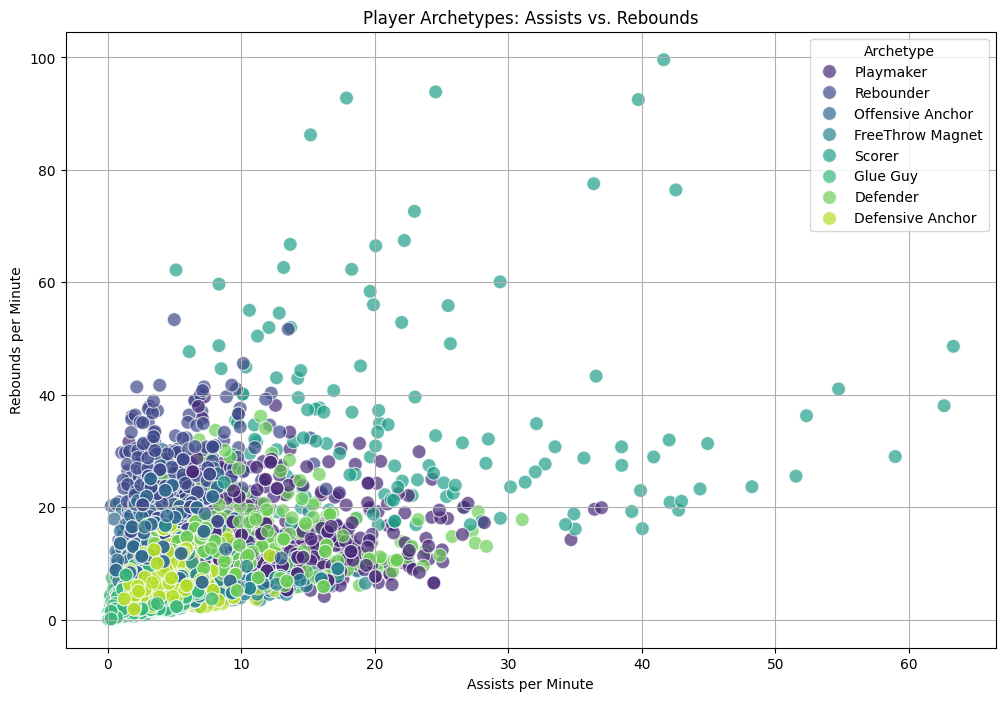

In [74]:
player_df['team_merge_key'] = player_df['team'].map(team_mapping).str.upper()
team_df['team_merge_key'] = team_df['Team'].str.upper()

# Select only the columns we need from the team data
team_wins_df = team_df[['team_merge_key', 'season', 'wins']]

# Perform the merge
df_merged = pd.merge(
    player_df,
    team_wins_df,
    on=['team_merge_key', 'season'],
    how='left'
)
df_merged = df_merged.drop(columns=['team_merge_key'])

df_cluster = df_merged[df_merged['minutesPlayed'] >= 500].copy()

# Avoid division by zero by replacing 0s with a small number where necessary
df_cluster['total_fieldAttempts'].replace(0, 1, inplace=True)
df_cluster['minutesPlayed'].replace(0, 1, inplace=True)

df_cluster['assists_per_min'] = df_cluster['total_assists'] / df_cluster['minutesPlayed']
df_cluster['rebounds_per_min'] = df_cluster['total_totalRb'] / df_cluster['minutesPlayed']
df_cluster['blocks_per_min'] = df_cluster['total_blocks'] / df_cluster['minutesPlayed']
df_cluster['steals_per_min'] = df_cluster['total_steals'] / df_cluster['minutesPlayed']
df_cluster['three_point_rate'] = df_cluster['total_threeAttempts'] / df_cluster['total_fieldAttempts']
df_cluster['total_points/32'] = df_cluster['total_points'] / df_cluster['minutesPlayed'] * 32
df_cluster['total_assists/32'] = df_cluster['total_assists'] / df_cluster['minutesPlayed'] * 32
df_cluster['total_totalRb/32'] = df_cluster['total_totalRb'] / df_cluster['minutesPlayed'] * 32
df_cluster['total_steals/32'] = df_cluster['total_steals'] / df_cluster['minutesPlayed'] * 32
df_cluster['total_blocks/32'] = df_cluster['total_blocks'] / df_cluster['minutesPlayed'] * 32
df_cluster['total_ftAttempts/32'] = df_cluster['total_ftAttempts'] / df_cluster['minutesPlayed'] * 32
df_cluster['offensiveWS/32'] = df_cluster['offensiveWS'] / df_cluster['minutesPlayed'] * 32
df_cluster['defensiveWS/32'] = df_cluster['defensiveWS'] / df_cluster['minutesPlayed'] * 32

df_cluster['free_throws/32'] = df_cluster['total_ftAttempts'] / df_cluster['minutesPlayed'] * 32

features = [
    'usagePercent',
    'blocks_per_min',
    'steals_per_min',
    'three_point_rate',
    'free_throws/32',
    'total_points/32',
    'total_assists/32',
    'total_totalRb/32',
    'total_steals/32',
    'total_blocks/32',
    'total_ftAttempts/32',
    'offensiveWS/32',
    'defensiveWS/32',

]

df_cluster.dropna(subset=features, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# We are aiming for 8 archetypes
kmeans = KMeans(n_clusters=8, random_state=6, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print("\n--- Cluster Analysis ---")
print("Analyzing clusters to assign archetype labels...")

cluster_analysis = df_cluster.groupby('cluster')[features].mean()
position_distribution = df_cluster.groupby('cluster')['position'].value_counts(normalize=True).unstack().fillna(0)
analysis_summary = pd.concat([cluster_analysis, position_distribution], axis=1)
print("\nCluster Profiles (Averages & Position Distribution):")
print(analysis_summary.round(2))

# --- Archetype assignment logic for 8 clusters using standardized stats ---

# Define the columns to use for archetype clustering

archetype_features = features

# Standardize the features for archetype clustering/analysis
archetype_scaler = StandardScaler()
X_archetype = archetype_scaler.fit_transform(df_cluster[archetype_features])

# Run KMeans clustering for archetype assignment
kmeans_archetype = KMeans(n_clusters=8, random_state=6, n_init=10)
df_cluster['archetype_cluster'] = kmeans_archetype.fit_predict(X_archetype)

# Analyze cluster means for archetype features
archetype_cluster_means = df_cluster.groupby('archetype_cluster')[archetype_features].mean()

# Assign archetype labels based on cluster means
archetype_map = {}

# 1. "Scorer": highest total_points/32
scorer_cluster = archetype_cluster_means['total_points/32'].idxmax()
archetype_map[scorer_cluster] = "Scorer"

# 2. "Playmaker": highest total_assists/32 (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
playmaker_cluster = archetype_cluster_means.loc[remaining]['total_assists/32'].idxmax()
archetype_map[playmaker_cluster] = "Playmaker"

# 3. "Rebounder": highest total_totalRb/32 (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
rebounder_cluster = archetype_cluster_means.loc[remaining]['total_totalRb/32'].idxmax()
archetype_map[rebounder_cluster] = "Rebounder"

# 4. "Defender": highest (total_steals/32 + total_blocks/32) (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
defense_score = (
    archetype_cluster_means.loc[remaining]['total_steals/32'] +
    archetype_cluster_means.loc[remaining]['total_blocks/32']
)
defender_cluster = defense_score.idxmax()
archetype_map[defender_cluster] = "Defender"

# 5. "FreeThrow Magnet": highest total_ftAttempts/32 (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
ft_cluster = archetype_cluster_means.loc[remaining]['total_ftAttempts/32'].idxmax()
archetype_map[ft_cluster] = "FreeThrow Magnet"

# 6. "Offensive Anchor": highest offensiveWS/32 (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
off_anchor_cluster = archetype_cluster_means.loc[remaining]['offensiveWS/32'].idxmax()
archetype_map[off_anchor_cluster] = "Offensive Anchor"

# 7. "Defensive Anchor": highest defensiveWS/32 (not already assigned)
remaining = [c for c in range(8) if c not in archetype_map]
def_anchor_cluster = archetype_cluster_means.loc[remaining]['defensiveWS/32'].idxmax()
archetype_map[def_anchor_cluster] = "Defensive Anchor"

# 8. "Glue Guy": assign to the last remaining cluster
remaining = [c for c in range(8) if c not in archetype_map]
if len(remaining) == 1:
    archetype_map[remaining[0]] = "Glue Guy"

print("\nAutomatically generated archetype map (based on standardized stats):")
print(archetype_map)

# Add the final archetype labels to the full DataFrame
df_cluster['archetype'] = df_cluster['cluster'].map(archetype_map)
df_final = df_merged.merge(df_cluster[['playerId', 'season', 'archetype']], on=['playerId', 'season'], how='left')

# For players with < 500 minutes, we can fill their archetype as 'Role Player'
df_final['archetype'].fillna('Role Player', inplace=True)

# --- 7. Final Output ---
print("\n--- Final Dataset ---")
print("Archetype column has been added.")

# Display the counts of each new archetype
print("\nArchetype Distribution:")
print(df_final['archetype'].value_counts())

# Display the first few rows with the new column
print("\nDataFrame Head with Archetypes:")
print(df_final[['playerName', 'season', 'team', 'position', 'archetype', 'wins']].head())

# Save the final, complete dataset to a new CSV
final_filename = "nba_master_dataset_with_archetypes.csv"
df_final.to_csv(final_filename, index=False)

# --- 8. Visualization (Optional) ---
# Visualize the clusters to see how they separate
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_cluster,
    x='assists_per_min',
    y='rebounds_per_min',
    hue='archetype',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('Player Archetypes: Assists vs. Rebounds')
plt.xlabel('Assists per Minute')
plt.ylabel('Rebounds per Minute')
plt.legend(title='Archetype')
plt.grid(True)

plt.show()

In [125]:
df_season

,playerId,playerName,season,age,team,position,games,minutesPlayed,total_points,total_assists,total_totalRb,total_offensiveRb,total_defensiveRb,total_steals,total_blocks,total_turnovers,total_personalFouls,total_fieldAttempts,total_fieldGoals,total_threeAttempts,total_threeFg,total_ftAttempts,total_ft,tsPercent,usagePercent,offensiveWS,defensiveWS,winShares,vorp,box,wins,archetype,points_p32,assists_p32,orebounds_p32,turnovers_p32,drebounds_p32,steals_p32,blocks_p32,fouls_p32,missed_fga_p32,missed_fta_p32,z_points,z_assists,z_orebounds,z_turnovers,z_missed_fga,z_missed_fta,z_drebounds,z_steals,z_blocks,z_fouls,team_season,team_id,archetype_id,position_code
0,hardeja01,James Harden,2015,25,HOU,SG,81,2981.0,179577,45765,37179,6075,31104,12474,4860,26001,16848,119070,52407,44955,16848,66744,57915,0.605,31.3,12.2,4.2,16.4,8.1,8.8,56.0,Playmaker,1927.696746,491.271385,65.213016,279.111707,333.890641,133.904059,52.170413,180.857430,715.604160,94.776250,1.675850,1.611806,0.019624,2.000914,1.241412,1.580969,0.539216,1.554075,0.619964,0.378309,HOU_2015,111,6,2
1,curryst01,Stephen Curry,2015,26,GSW,PG,80,2613.0,152000,49520,27280,4480,22800,13040,1280,19920,12640,107280,52240,51680,22880,26960,24640,0.638,28.9,11.5,4.1,15.7,7.9,9.9,67.0,Playmaker,1861.461921,606.444700,54.864141,243.949483,279.219288,159.693838,15.675469,154.795254,674.045159,28.411787,1.584304,2.181799,-0.100041,1.630150,1.111954,-0.078289,0.296242,2.041929,-0.316941,0.174640,GSW_2015,100,6,1
2,westbru01,Russell Westbrook,2015,26,OKC,PG,67,2302.0,126362,38458,32696,8308,24388,9380,938,19631,12328,98557,42009,19296,5762,43818,36582,0.536,38.4,7.5,3.2,10.6,5.8,8.1,45.0,Playmaker,1756.552563,534.602954,115.489140,272.889661,339.016507,130.390964,13.039096,171.370982,786.071242,100.587315,1.439305,1.826254,0.600971,1.935307,1.460920,1.726258,0.561996,1.487620,-0.384623,0.304175,OKC_2015,219,6,1
3,jamesle01,LeBron James,2015,30,CLE,SF,69,2493.0,120267,35259,28704,3519,25185,7521,3381,18768,9315,88251,43056,23391,8280,36432,25875,0.577,32.3,7.4,2.9,10.4,5.7,7.1,53.0,Playmaker,1543.740072,452.582431,45.169675,240.904934,323.273165,96.539110,43.398315,119.566787,580.120337,135.509025,1.145168,1.420334,-0.212139,1.598048,0.819374,2.599378,0.492029,0.847259,0.394765,-0.100660,CLE_2015,56,6,3
4,lillada01,Damian Lillard,2015,24,POR,PG,82,2925.0,141040,41574,30996,4018,26978,7954,1722,18204,13448,111520,48380,46904,16072,32636,28208,0.560,26.9,7.3,3.3,10.6,4.9,4.7,51.0,Playmaker,1543.001709,454.826667,43.957607,199.154872,295.143932,87.018120,18.838974,147.123419,690.762393,48.443077,1.144147,1.431440,-0.226154,1.157819,1.164029,0.422538,0.367015,0.667154,-0.235727,0.114687,POR_2015,263,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47264,minixri01,Riley Minix,2025,24,SAS,SF,1,7.0,0,0,2,0,2,0,0,0,0,1,0,1,0,0,0,0.000,6.1,0.0,0.0,0.0,0.0,-11.8,34.0,Role Player,0.000000,0.000000,0.000000,0.000000,9.142857,0.000000,0.000000,0.000000,4.571429,0.000000,-0.988499,-0.819499,-0.734440,-0.942146,-0.973486,-0.788646,-0.904046,-0.978930,-0.719365,-1.035039,SAS_2025,295,8,3
47266,okafoja01,Jahlil Okafor,2025,29,IND,C,1,3.0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0.0,0.0,0.0,0.0,7.5,50.0,Role Player,0.000000,10.666667,0.000000,0.000000,10.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-0.988499,-0.766709,-0.734440,-0.942146,-0.987726,-0.788646,-0.897274,-0.978930,-0.719365,-1.035039,IND_2025,132,8,5
47268,pullizy01,Zyon Pullin,2025,23,MEM,SG,3,3.0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0.000,13.4,0.0,0.0,0.0,0.0,-22.7,48.0,Role Player,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,-0.988499,-0.819499,-0.734440,-0.942146,-0.888045,-0.788646,-0.944679,-0.978930,-0.719365,-1.035039,MEM_2025,163,8,2
47270,steveis01,Isaiah Stevens,2025,24,MIA,PG,3,6.0,0,0,6,0,6,3,0,0,0,6,0,3,0,0,0

In [142]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- 1. Load and Prepare Data ---
df = pd.read_csv('nba_master_dataset_with_archetypes.csv')

SEASON_TO_RUN = 2025
MIN_MINUTES_QUALIFY = 500  # Threshold for the standardization pool

# Only use the selected season and players with minutes > 0 for per-32/min calculations
df_season = df[(df['season'] == SEASON_TO_RUN) & (df['minutesPlayed'] > 0)].copy()
df_season = df
print(f"Preparing standardized data for the {SEASON_TO_RUN} season...")

# --- 2. Calculate Per-32 Minute Rates ---
rate_stats_to_calc = {
    'points_p32': 'total_points',
    'assists_p32': 'total_assists',
    'orebounds_p32': 'total_offensiveRb',
    'turnovers_p32': 'total_turnovers',
    'drebounds_p32': 'total_defensiveRb',
    'steals_p32': 'total_steals',
    'blocks_p32': 'total_blocks',
    'fouls_p32': 'total_personalFouls'
}
for new_col, old_col in rate_stats_to_calc.items():
    df_season[new_col] = (df_season[old_col] / df_season['minutesPlayed']) * 32

df_season['missed_fga_p32'] = ((df_season['total_fieldAttempts'] - df_season['total_fieldGoals']) / df_season['minutesPlayed']) * 32
df_season['missed_fta_p32'] = ((df_season['total_ftAttempts'] - df_season['total_ft']) / df_season['minutesPlayed']) * 32

# --- 3. Standardize the Data (fit scaler only on players with > 500 minutes) ---
features_to_standardize = [
    'points_p32', 'assists_p32', 'orebounds_p32', 'turnovers_p32',
    'missed_fga_p32', 'missed_fta_p32', 'drebounds_p32', 'steals_p32',
    'blocks_p32', 'fouls_p32'
]

# Fill any potential NaNs that result from division by zero minutes
df_season[features_to_standardize] = df_season[features_to_standardize].fillna(0)

# Fit the scaler ONLY on players with > 500 minutes
qualified_players = df_season[df_season['minutesPlayed'] > MIN_MINUTES_QUALIFY]
scaler = StandardScaler().fit(qualified_players[features_to_standardize])

# Transform ALL players using that fitted scaler
scaled_features = scaler.transform(df_season[features_to_standardize])

# Add the new z-score columns to the DataFrame
z_score_cols = [
    "z_points", "z_assists", "z_orebounds", "z_turnovers", "z_missed_fga",
    "z_missed_fta", "z_drebounds", "z_steals", "z_blocks", "z_fouls"
]
for i, col_name in enumerate(z_score_cols):
    df_season[col_name] = scaled_features[:, i]

# --- 4. Format Data for Stan ---
df_season.dropna(inplace=True)
df_season['team_season'] = df_season['team'] + "_" + df_season['season'].astype(str)
df_season['team_id'] = pd.Categorical(df_season['team_season']).codes + 1
df_season['archetype_id'] = pd.Categorical(df_season['archetype']).codes + 1

df_season.drop_duplicates(subset=['playerName', 'season'], inplace=True)

# Sanity checks
assert not df_season.isnull().any().any(), "NaNs present in df_season!"
assert len(df_season) == len(df_season['team_id']), "Mismatch in player count and team_id length"
assert df_season['team_id'].min() == 1, "team_id should be 1-indexed"
assert df_season['archetype_id'].min() == 1, "archetype_id should be 1-indexed"
assert len(df_season.groupby('team_id')['wins'].first()) == df_season['team_id'].nunique(), "team_wins length mismatch"

df_season['position_code'] = df_season['position'].map({
    'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5
})

stan_data = {
    "N_players": len(df_season),
    "N_teams": df_season['team_id'].nunique(),
    "N_archetypes": df_season['archetype_id'].nunique(),
    "team_id": df_season['team_id'].tolist(),
    "archetype_id": df_season['archetype_id'].tolist(),
    "total_minutes_played": df_season['minutesPlayed'].tolist(),
    "team_wins": df_season.groupby('team_id')['wins'].first().tolist(),
    "position": df_season['position_code'].tolist(),
    "z_points": df_season['z_points'].tolist(),
    "z_assists": df_season['z_assists'].tolist(),
    "z_orebounds": df_season['z_orebounds'].tolist(),
    "z_turnovers": df_season['z_turnovers'].tolist(),
    "z_missed_fga": df_season['z_missed_fga'].tolist(),
    "z_missed_fta": df_season['z_missed_fta'].tolist(),
    "z_drebounds": df_season['z_drebounds'].tolist(),
    "z_steals": df_season['z_steals'].tolist(),
    "z_blocks": df_season['z_blocks'].tolist(),
    "z_fouls": df_season['z_fouls'].tolist()
}

print("\nDone!")

Preparing standardized data for the 2025 season...

Done!


In [143]:
print("Compiling Stan model...")
stan_file = "/Users/reececalvin/BOOKER/full_model/booker.stan"
model = CmdStanModel(stan_file=stan_file)

print("Model compiled. Starting MCMC sampling...")
fit = model.sample(
    data=stan_data,
    seed=6,
    chains=4,
    parallel_chains=4
)
print("Sampling complete.")

# --- 6. Extract and Display Results ---
print("\nExtracting results from the model fit...")

war_estimates = fit.stan_variable('war')  # shape: (n_draws, N_players) or (N_players,) if only one draw

# If war_estimates is 2D (n_draws, N_players), take mean across draws for each player
if war_estimates.ndim == 2 and war_estimates.shape[1] == len(df_season):
    war_mean = war_estimates.mean(axis=0)
elif war_estimates.ndim == 1 and war_estimates.shape[0] == len(df_season):
    war_mean = war_estimates
else:
    raise ValueError(f"Shape of war_estimates ({war_estimates.shape}) does not match number of players ({len(df_season)})")

df_season['WAR'] = war_mean

# Extract and add all the beta*z scores (means across draws)
for var in [
    'beta_points_z', 'beta_assists_z', 'beta_orebounds_z',
    'beta_missed_fga_z', 'beta_missed_fta_z', 'beta_drebounds_z', 'beta_steals_z'
]:
    arr = fit.stan_variable(var)
    if arr.ndim == 2 and arr.shape[1] == len(df_season):
        arr_mean = arr.mean(axis=0)
    elif arr.ndim == 1 and arr.shape[0] == len(df_season):
        arr_mean = arr
    else:
        raise ValueError(f"Shape of {var} ({arr.shape}) does not match number of players ({len(df_season)})")
    df_season[var] = arr_mean

final_report = df_season[['season', 'playerName', 'team', 'minutesPlayed', 'WAR', 'beta_points_z', 'beta_assists_z', 'beta_orebounds_z', 'beta_missed_fga_z', 'beta_missed_fta_z', 'beta_drebounds_z', 'beta_steals_z']].copy()

print("\n--- Bayesian Wins Above Replacement Rankings (2025) ---")
print(final_report.sort_values(by='WAR', ascending=False).head(25).round(2).to_string(index=False))

00:30:07 - cmdstanpy - INFO - CmdStan start processing


Compiling Stan model...
Model compiled. Starting MCMC sampling...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:35:43 - cmdstanpy - INFO - CmdStan done processing.
00:35:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'booker.stan', line 85, column 4 to column 53)
Exception: normal_l


Sampling complete.

Extracting results from the model fit...

--- Bayesian Wins Above Replacement Rankings (2025) ---
 season              playerName team  minutesPlayed   WAR  beta_points_z  beta_assists_z  beta_orebounds_z  beta_missed_fga_z  beta_missed_fta_z  beta_drebounds_z  beta_steals_z
   2025 Shai Gilgeous-Alexander  OKC         2598.0 16.85           6.97            0.60             -0.01              -0.78              -0.24              0.12           0.27
   2018            LeBron James  CLE         3026.0 16.39           4.88            1.93              0.13              -0.60              -0.68              0.60           0.17
   2019            James Harden  HOU         2867.0 15.79           7.53            0.72             -0.05              -1.12              -0.44              0.28           0.32
   2017       Russell Westbrook  OKC         2802.0 15.78           7.15            1.27              0.50              -1.31              -0.66              0.71       

In [ ]:
fit.stan_variable

In [146]:
# booker_war is likely (n_draws, N_players) or (N_players,) -- need to aggregate to match df_season
booker_war_arr = fit.stan_variable('booker_war')
if booker_war_arr.ndim == 2 and booker_war_arr.shape[1] == len(df_season):
    booker_war_mean = booker_war_arr.mean(axis=0)
elif booker_war_arr.ndim == 1 and booker_war_arr.shape[0] == len(df_season):
    booker_war_mean = booker_war_arr
else:
    raise ValueError(f"Shape of booker_war ({booker_war_arr.shape}) does not match number of players ({len(df_season)})")
df_season['booker_war'] = booker_war_mean

In [ ]:
df_season.groupby(['season', 'team']).agg({'booker_war': 'sum', 'WAR': 'sum', 'wins': 'mean', 'offensiveWS':'sum', 'defensiveWS': 'sum', 'winShares': 'sum', 'vorp': 'sum', 'box': 'sum'}).sort_values('WAR', ascending=False)

,booker_war,WAR,wins,offensiveWS,defensiveWS,winShares,vorp,box
season,,,,,,,,
2024,442.607292,1075.426887,39.435398,657.3,591.7,1250.2,303.1,-962.8
2023,474.335385,982.620474,40.272897,650.3,595.6,1245.8,296.4,-734.5
2019,512.343416,971.715623,40.384321,644.5,590.2,1235.4,304.3,-866.4
2025,520.741659,954.253172,39.784810,637.5,569.9,1208.4,287.5,-820.3
2017,492.396258,953.470282,40.414079,647.3,599.8,1246.8,302.3,-691.7
2018,489.218536,938.771238,40.363806,651.9,592.3,1246.1,301.2,-623.1
2016,493.739905,921.309896,40.360169,652.4,594.7,1246.0,300.6,-501.2
2022,345.607301,890.133248,40.487479,655.8,592.3,1251.0,305.6,-1193.2
2015,435.499198,732.198872,39.423729,620.7,573.6,1195.9,289.2,-689.6


In [ ]:
df_season = df_season.sort_values(['playerId', 'season'])
df_season['next_season_war'] = df_season.groupby('playerId')['WAR'].shift(-1)
df_season['next_season_winShare'] = df_season.groupby('playerId')['winShares'].shift(-1)
df_season['next_season_vorp'] = df_season.groupby('playerId')['vorp'].shift(-1)
df_season['next_season_box'] = df_season.groupby('playerId')['box'].shift(-1)
df_season['next_season_offensiveWS'] = df_season.groupby('playerId')['offensiveWS'].shift(-1)
df_season['next_season_defensiveWS'] = df_season.groupby('playerId')['defensiveWS'].shift(-1)

In [184]:
df_season[['playerName', 'season', 'team', 'WAR', 'next_season_war', 'winShares', 'next_season_winShare', 'vorp', 'next_season_vorp', 'box', 'next_season_box', 'offensiveWS', 'next_season_offensiveWS', 'defensiveWS', 'next_season_defensiveWS']].corr(numeric_only=True)

,season,WAR,next_season_war,winShares,next_season_winShare,vorp,next_season_vorp,box,next_season_box,offensiveWS,next_season_offensiveWS,defensiveWS,next_season_defensiveWS
season,1.000000,-0.008556,-0.019669,-0.052693,-0.045283,-0.028954,-0.020518,-0.020186,0.007142,-0.037710,-0.033697,-0.067993,-0.056980
WAR,-0.008556,1.000000,0.633424,0.890252,0.655628,0.817640,0.648137,0.359507,0.396488,0.833552,0.614781,0.800560,0.582632
next_season_war,-0.019669,0.633424,1.000000,0.637105,0.890401,0.621504,0.823358,0.307024,0.460260,0.597545,0.836322,0.556726,0.789046
winShares,-0.052693,0.890252,0.637105,1.000000,0.742055,0.900610,0.708518,0.438212,0.446084,0.957230,0.710151,0.862693,0.634189
next_season_winShare,-0.045283,0.655628,0.890401,0.742055,1.000000,0.701418,0.902446,0.362227,0.557627,0.706149,0.957219,0.630600,0.853793
vorp,-0.028954,0.817640,0.621504,0.900610,0.701418,1.000000,0.790430,0.439047,0.468297,0.889807,0.684994,0.728765,0.574543
next_season_vorp,-0.020518,0.648137,0.823358,0.708518,0.902446,0.790430,1.000000,0.386135,0.575896,0.688797,0.888573,0.575401,0.726356
box,-0.020186,0.359507,0.307024,0.438212,0.362227,0.439047,0.386135,1.000000,0.247960,0.417650,0.345629,0.381496,0.311708
next_season_box,0.007142,0.396488,0.460260,0.446084,0.557627,0.468297,0.575896,0.247960,1.000000,0.421657,0.534408,0.384122,0.475158
offensiveWS,-0.037710,0.833552,0.597545,0.957230,0.706149,0.889807,0.688797,0.417650,0.421657,1.000000,0.724785,0.680107,0.515249


<Axes: xlabel='WAR', ylabel='winShares'>

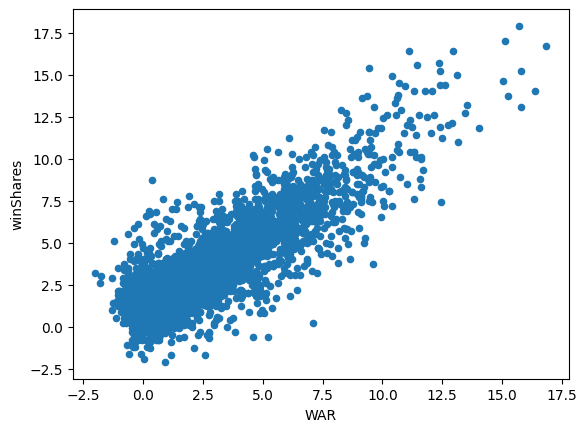

In [174]:
df_season.plot.scatter(x='WAR', y='winShares')

In [ ]:
df_season.corr(numeric_only=True).sort_values(by='winShares', ascending=False)[['vorp', 'offensiveWS', 'defensiveWS', 'winShares', 'box']]

,playerId,playerName,season,age,team,position,games,minutesPlayed,total_points,total_assists,total_totalRb,total_offensiveRb,total_defensiveRb,total_steals,total_blocks,total_turnovers,total_personalFouls,total_fieldAttempts,total_fieldGoals,total_threeAttempts,total_threeFg,total_ftAttempts,total_ft,tsPercent,usagePercent,offensiveWS,defensiveWS,winShares,vorp,box,wins,archetype,points_p32,assists_p32,orebounds_p32,turnovers_p32,drebounds_p32,steals_p32,blocks_p32,fouls_p32,missed_fga_p32,missed_fta_p32,z_points,z_assists,z_orebounds,z_turnovers,z_missed_fga,z_missed_fta,z_drebounds,z_steals,z_blocks,z_fouls,team_season,team_id,archetype_id,position_code,WAR,beta_points_z,beta_assists_z,beta_orebounds_z,beta_missed_fga_z,beta_missed_fta_z,beta_drebounds_z,beta_steals_z
36651,gilgesh01,Shai Gilgeous-Alexander,2025,26,OKC,PG,76,2598.0,188784,36936,28804,5092,23712,9956,5852,13908,12464,125856,65360,33060,12388,50844,45676,0.637,34.8,11.9,4.8,16.7,8.9,11.5,68.0,Playmaker,2325.284065,454.946882,62.719015,171.307159,292.064665,122.629715,72.080062,153.521170,745.139338,63.655119,2.433840,1.435881,0.110471,1.001382,1.575642,1.144055,0.583925,1.670180,1.827050,0.362220,OKC_2025,20,6,1,15.127992,7.367465,0.813413,0.074121,-0.687086,-0.481228,0.130705,0.282895
36655,edwaran01,Anthony Edwards,2025,23,MIN,SG,79,2871.0,171983,28361,35550,4819,30731,7189,4029,19671,11850,127348,56959,64069,25280,39184,32785,0.595,31.4,4.6,3.8,8.4,4.6,4.3,49.0,Playmaker,1916.912574,316.110066,53.712295,219.251829,342.525949,80.128178,44.907001,132.079415,784.551724,71.322884,1.833365,0.737863,-0.011677,1.548229,1.710586,1.388747,0.850995,0.733913,0.831967,0.171895,MIN_2025,17,6,2,11.020200,5.474122,0.554568,-0.008501,-0.746438,-0.508713,0.261708,0.237532
36659,jokicni01,Nikola Jokić,2025,29,DEN,C,70,2571.0,144970,50120,62440,14000,48440,8890,3150,16100,11200,95480,55020,23170,9660,31570,25270,0.663,29.5,12.7,3.8,16.4,9.8,13.3,50.0,Playmaker,1804.371840,623.819525,174.251264,200.388954,602.909374,110.649553,39.206534,139.401011,503.586153,78.413069,1.667884,2.284906,1.623061,1.333083,0.748588,1.615008,2.229094,1.406269,0.623215,0.236884,DEN_2025,8,6,5,14.542752,4.975224,1.644117,1.105712,-0.329109,-0.453807,0.514295,0.303959
36663,antetgi01,Giannis Antetokounmpo,2025,30,MIL,PF,67,2289.0,136412,29011,53466,9849,43617,3886,5226,13802,10385,88373,53131,4221,938,47369,29212,0.625,35.2,7.8,3.7,11.5,6.6,9.5,48.0,Playmaker,1907.026649,405.570992,137.688073,192.950633,609.761468,54.325907,73.058978,145.181302,492.679773,253.833115,1.818829,1.187638,1.127194,1.248243,0.711246,7.212985,2.265359,0.165515,1.862898,0.288192,MIL_2025,16,6,4,10.977489,5.364928,0.889078,0.727971,-0.322474,-1.409749,0.751315,0.028498
36667,tatumja01,Jayson Tatum,2025,26,BOS,PF,72,2624.0,139104,31032,44856,3456,41400,5472,2736,15048,11304,105480,47664,52416,18000,31680,25776,0.582,31.2,5.3,4.2,9.5,4.8,5.2,61.0,Playmaker,1696.390244,378.439024,42.146341,183.512195,504.878049,66.731707,33.365854,137.853659,705.073171,72.000000,1.509107,1.051229,-0.168534,1.140590,1.438459,1.410355,1.710256,0.438802,0.409328,0.223149,BOS_2025,2,6,4,9.662549,4.451353,0.786961,-0.108843,-0.652187,-0.275648,0.567213,0.075553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47264,minixri01,Riley Minix,2025,24,SAS,SF,1,7.0,0,0,2,0,2,0,0,0,0,1,0,1,0,0,0,0.000,6.1,0.0,0.0,0.0,0.0,-11.8,34.0,Role Player,0.000000,0.000000,0.000000,0.000000,9.142857,0.000000,0.000000,0.000000,4.571429,0.000000,-0.985285,-0.851415,-0.740118,-0.952514,-0.959988,-0.887298,-0.913461,-1.031231,-0.812537,-1.000494,SAS_2025,26,8,3,-0.011648,-2.936852,-0.674910,-0.454319,0.401528,0.286510,-0.247685,-0.166638
47266,okafoja01,Jahlil Okafor,2025,29,IND,C,1,3.0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0.0,0.0,0.0,0.0,7.5,50.0,Role Player,0.000